# Matched Field Processing with KRAKEN Acoustic Propagation Model

This notebook demonstrates how to use TritonOA and KRAKEN to perform matched field processing (MFP) using the Munk sound speed profile.

In [10]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from tritonoa.at.models.kraken import runner
from tritonoa.plotting import plot_ambiguity_surface
from tritonoa.sp.beamforming import covariance
from tritonoa.sp.mfp import MatchedFieldProcessor
from tritonoa.sp.beamforming import beamformer

# Shallow-water, upward-refracting environment
z_data = np.array([0, 200])
c_data = np.array([1475, 1525])

environment = {
    # 1. General
    "title": "Iso-speed",
    "model": "KRAKEN",
    # 2. Top medium (halfspace)
    # 3. Layered media
    "layerdata": [{"z": z_data, "c_p": c_data, "rho": 1.0}],
    # 4. Bottom medium
    "bot_opt": "A",
    "bot_c_p": 1580,
    "bot_rho": 1.76,
    "bot_a_p": 0.2,
    # 5. Speed constraints
    "clow": 0,
    "chigh": 1600,
    # 6. Receiver parameters
    "rec_z": np.arange(130, 194, 4).tolist(),  # 16-element array w/ 4-m spacing
    "rec_r": 7.0,
    "tilt": 0,
    # 7. Source parameters
    "src_z": 50.0,
    # "snr_db": 10,
}

freqs = [100, 150, 200]

covariance_matrix = []
for f in freqs:
    p_actual = runner.run_kraken(
        environment | {"freq": f}
    )  # Add the frequency to the environment
    p_actual /= np.linalg.norm(p_actual)  # Normalize
    K = covariance(p_actual)
    covariance_matrix.append(K)

processor = MatchedFieldProcessor(
    runner=runner.run_kraken,
    covariance_matrix=covariance_matrix,
    freq=freqs,
    parameters=environment,
    beamformer=partial(beamformer, atype="cbf"),
    multifreq_method="product",
)

# Search space for range & depth
rvec = np.linspace(2, 10, 100)  # km
zvec = np.linspace(1, 200, 40)  # m

# MFP Loop
ambiguity_surface = np.zeros((len(zvec), len(rvec)))
for zz, z in enumerate(tqdm(zvec)):
    ambiguity_surface[zz, :] = processor({"src_z": z, "rec_r": rvec, "tilt": 0})

100%|██████████| 40/40 [00:01<00:00, 30.39it/s]


Next, the ambiguity surface is normalized and plotted with a decibel scale.

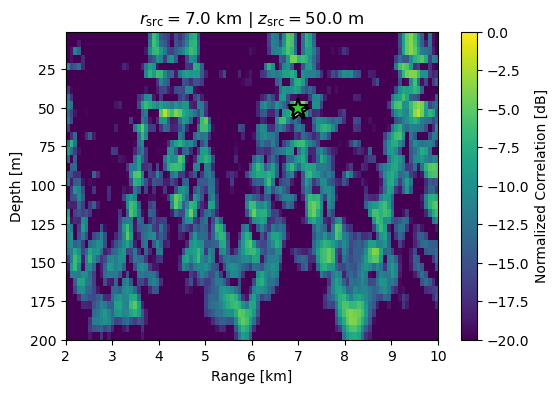

In [13]:
PLOT_DEFAULTS = {
    "marker": "*",
    "markersize": 15,
    "markeredgewidth": 1.5,
    "markeredgecolor": "k",
    "markerfacecolor": "limegreen",
}

amb_norm = ambiguity_surface
amb_norm /= amb_norm.max()
amb_norm = 10 * np.log10(amb_norm)
vmin = -20.0
vmax = 0.0

fig = plt.figure(figsize=(6, 4), facecolor="white", dpi=100)
_, im = plot_ambiguity_surface(
    amb_norm, rvec, zvec, imshow_kwargs={"vmin": vmin, "vmax": vmax, "cmap": "viridis"}
)
plt.plot(environment["rec_r"], environment["src_z"], zorder=50, **PLOT_DEFAULTS)
plt.xlabel("Range [km]")
plt.ylabel("Depth [m]")
cbar = plt.colorbar(im)
cbar.set_label("Normalized Correlation [dB]")
plt.title(
    f"$r_\mathrm{{src}} = {environment['rec_r']}$ km | "
    f"$z_\mathrm{{src}} = {environment['src_z']}$ m"
)
plt.show()